I'll use this notebook to implement and test a numerical tool for converting from action-angle coordinates to Cartesian coordinates.

In [12]:
# import packages
import numpy as np
import scipy.integrate as integrate
import scipy.misc
import time

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation

from matplotlib import cm
from matplotlib.ticker import LinearLocator
## set default plot size
plt.rcParams["figure.figsize"] = (10, 7)
## set global font size
plt.rcParams.update({'font.size':14})

import astropy.units as u
from astropy import constants as const

import scipy.integrate as integrate

# Step 1: Derive $J(E)$

In [8]:
np.cosh(-10)

11013.232920103323

In [27]:
## define Phi, positive v_z, and J(E)
def Phi(z):
    '''
    Represents the (dimensionless) slab potential.
    
    '''
    
    return 2 * np.log(np.cosh(z / 2))

def v_z_positive(z, E):
    '''
    Represents the (positive) v_z corresponding to a given z and E; i.e.,
    v_z = +sqrt[2*(E-Phi(z))]. 
    
    '''
    
    return np.sqrt(2*(E-Phi(z)))

def J_E(E): 
    '''
    Returns the numerical value of J corresponding to a given energy E.
    
    '''
    
    z_max = 2 * np.arccosh( np.exp(E/2) )
    return (2 / np.pi) * integrate.quad(v_z_positive, 0, z_max, args=(E))[0]

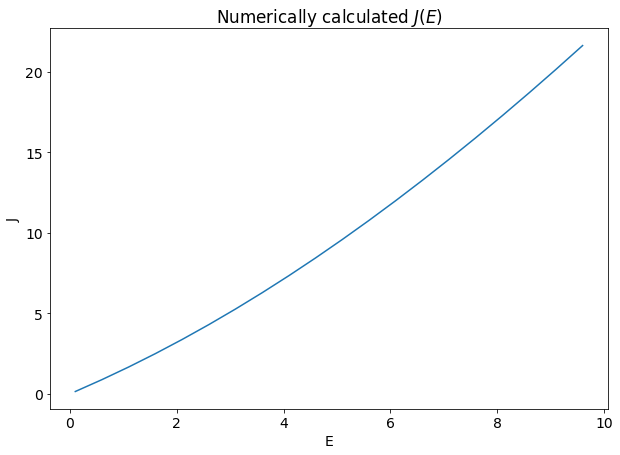

In [30]:
Es = np.arange(0.1, 10, 0.5)

J_E_vectorized = np.vectorize(J_E)

plt.plot(Es, J_E_vectorized(Es))
plt.xlabel("E")
plt.ylabel("J")

plt.title("Numerically calculated $J(E)$")
plt.show()

# Step 2: Derive $E(J)$

We'll have to invert J(E) from the previous step.